<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/mlp_eeg_nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install progress
from progress.bar import Bar

In [5]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp as ivp
from statistics import stdev

In [ ]:
###Added
import seaborn as sns
import pandas as pd


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
sfq = 250 # Было 250

In [7]:
class FloatingWindow():
    def __init__(self, arr_src, arr_trgt, sfreq=250, twin=1., vwin=1., step=1.):
        assert arr_src.shape == arr_trgt.shape, 'Source and target arrays should be in the same shape'
        assert len(arr_src.shape) == 1, 'Arrays should be 1D'
        self.data = np.vstack((arr_src, arr_trgt)).T
        self.twin = int(twin*sfreq)
        self.vwin = int(vwin*sfreq)
        self.step = int(step*sfreq)
        self.end = (self.data.shape[0] - (self.twin + self.vwin))//self.step
        self.coefs = []

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(1, activation='linear'))
        model.add(layers.Dense(20, activation='tanh'))
        model.add(layers.Dense(20, activation='tanh'))
        model.add(layers.Dense(1, activation='linear'))

        model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                        loss='mse',
                        metrics=[coeff_determination])
        return model
    
    def _train(self, src, trgt):
        self.model = self.get_model()
        self.model.fit(src, trgt, epochs=10, batch_size=32, verbose=False)
    
    def _predict(self, src_v, trgt_v):
        assert getattr(self, 'model', None) != None
        res = self.model.predict(src_v).T[0]
        return r2_score(trgt_v, res)

    def test_train(self):
        self.init_iter()
        self.coefs = []
        while self._iter != self.end:
            src, trgt, src_v, trgt_v = self.get_sets()
            self._train(src, trgt)
            self.coefs.append(self._predict(src_v, trgt_v))
            self.inc_iter()
    
    def init_iter(self):
        self._iter = 0

    def inc_iter(self):
        self._iter += 1

    def get_win(self):
        win = self.data[self.step*self._iter : self.step*self._iter + self.twin + self.vwin]
        train = win[:self.twin].T
        validate = win[self.twin:].T
        return train, validate
    
    def get_sets(self):
        train, validate = self.get_win()
        src = train[0][np.newaxis, :].T         # shape (n, 1)
        trgt = train[1][np.newaxis, :].T        # shape (n, 1)
        src_v = validate[0][np.newaxis, :].T     # shape (n, 1)
        trgt_v = validate[1]                     # shape (n,)
        return src, trgt, src_v, trgt_v


class PashorgWindow(FloatingWindow):
    
    def get_win(self):
        win = self.data[self.step*self._iter : self.step*self._iter + self.twin + self.vwin]
        win = np.random.permutation(win)
        train = win[:self.twin].T
        validate = win[self.twin:].T
        return train, validate


class CrossWindow(FloatingWindow):
    def __init__(self, arr_src, arr_trgt, n=5, sfreq=250, twin=1., vwin=1., step=1.):
        self.n = n
        super().__init__(arr_src, arr_trgt, sfreq=250, twin=1., vwin=1., step=1.)
        assert self.twin % self.n == 0, f'Train window split does not result in an equal division (size of twin: {self.twin})'
    
    def get_sets(self):
        train, validate = self.get_win()
        train = np.array(np.split(train, self.n, axis=-1))
        dt = []
        for i in range(self.n):
            temp = (
                train[i][0][np.newaxis, :].T,
                np.hstack(np.delete(train, i, axis=0))[0][np.newaxis, :].T,
                train[i][1],
                np.hstack(np.delete(train, i, axis=0))[1][np.newaxis, :].T
                )
            dt.append(temp)
        src_v = validate[0][np.newaxis, :].T
        trgt_v = validate[1]
        return dt, src_v, trgt_v

    def test_train(self):
        self.init_iter()
        self.coefs = []
        while self._iter != self.end:
            dt, src_v, trgt_v = self.get_sets()
            temp = []
            for src_vs, src_t, trgt_vs, trgt_t in dt:
                self._train(src_t, trgt_t)
                temp.append( (self._predict(src_vs, trgt_vs), self._predict(src_v, trgt_v)) )
            self.coefs.append(temp)
            self.inc_iter()       


In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.
    square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [9]:
def normalize(arr):
    shape = arr.shape
    its = 1
    size = shape[-1]
    temp_arr = arr.flatten()
    for shape_i in shape:
        its *= shape_i
    its //= size
    for i in range(its - 1):
        temp_slice = temp_arr[i*size : (i+1)*size]
        temp_arr[i*size : (i+1)*size] = (temp_slice - np.min(temp_slice))/(np.max(temp_slice) - np.min(temp_slice))
    temp_slice = temp_arr[(i+1)*size:]
    temp_arr[(i+1)*size:] = (temp_slice - np.min(temp_slice))/(np.max(temp_slice) - np.min(temp_slice))
    return temp_arr.reshape(*shape)

In [ ]:
r_mapping = {'O2': 0, 'O1': 1, 'P4': 2, 'P3': 3, 'C4': 4, 'C3': 5, 'F4': 6,
             'F3': 7, 'Fp2': 8, 'Fp1': 9, 'T6': 10, 'T5': 11, 'T4': 12,
             'T3': 13, 'F8': 14, 'F7': 15, 'Oz': 16, 'Pz': 17, 'Cz': 18,
             'Fz': 19, 'Fpz': 20, 'FT7': 21, 'FC3': 22, 'Fcz': 23, 'FC4': 24,
             'FT8': 25, 'TP7': 26, 'CP3': 27, 'Cpz': 28, 'CP4': 29, 'TP8': 30}
    

In [ ]:
def extract(data_stream):
    raw_data = data_stream.readlines()
    data = []
    for line in raw_data:
        temp = np.array([float(x) for x in line.split()])
        data.append(temp)
    return np.array(data)

def format_fname(_group, _hand, _subj, _tr_num):
    directory = 'drive/My Drive/Subjects'
    fname_pattern = f'{_group}_subject_{_subj}_{_hand}_tr_{_tr_num}.dat'
    return join(directory, fname_pattern)

hands = ('lefthand', 'righthand')
groups = ('OLD', 'YOUNG')
subjects = np.arange(1, 11)
trials = np.arange(1, 16)
total = len(hands)*len(groups)*len(subjects)*len(trials)

In [ ]:
epochs = []

for trial in trials:
    fin = open(format_fname('YOUNG', hands[1], subjects[0], trial))
    epochs.append(extract(fin))
    fin.close()

epochs = np.array(epochs)

In [ ]:
t = np.linspace(0, 12, 3001)
tp7 = epochs[::, r_mapping['TP7'], sfq*2::]
cz = epochs[::, r_mapping['Cz'], sfq*2::]
lowcut = 8.0
highcut = 12.0
cz_filtered = butter_bandpass_filter(cz, lowcut, highcut, sfq, order=6)
tp7_filtered = butter_bandpass_filter(tp7, lowcut, highcut, sfq, order=6)
temp = normalize(tp7_filtered)
tp7_filtered = np.array([(tp7_filtered[i] - np.min(tp7_filtered[i]))/(np.max(tp7_filtered[i]) - np.min(tp7_filtered[i])) for i in range(len(tp7_filtered))])
cz_filtered = np.array([(cz_filtered[i] - np.min(cz_filtered[i]))/(np.max(cz_filtered[i]) - np.min(cz_filtered[i])) for i in range(len(cz_filtered))])

In [10]:
def get_osc(epsylon=[0., 0.03], a=0.15, p=0.2, c=10, omega=[0.99, 0.95], fps=250, time=(0, 375)):
    def rossler(t, vec: np.array):
        res = np.zeros(6)
        x = vec[0:4:3]
        y = vec[1:5:3]
        z = vec[2:6:3]
        res[0:4:3] = -omega*y - z + epsylon*(x[::-1] - x)
        res[1:5:3] = omega*x + a*y
        res[2:6:3] = p + z*(x-c)
        return res
    omega = np.array(omega)
    epsylon = np.array(epsylon)
    start_time = time[0]
    end_time = time[1]
    X1 = 0
    Y1 = 1
    Z1 = 2
    X2 = 3
    Y2 = 4
    Z2 = 5
    t=np.linspace(start_time, end_time, num=int(fps*end_time))
    z0 = np.zeros(6)
    res1 = ivp(rossler, (start_time,end_time), z0, t_eval=t)
    y = res1['y'] # тут данные с шейпом (6, <fps*(end_time - start_time)>). Эти шесть временных рядов -- значения x1, y1, z1, x2, y2, z2 соответственно
    t_span = res1['t'] # тут время (можно использовать то, что выше)
    return normalize(y[[X1, X2]])[::, fps*100:]
# osc1 = norm_osc_data[0:3].T # матрица вида [[X1_1, Y1_1, Z1_1], [X1_2, Y1_2, Z1_2], [X1_3, Y1_3, Z1_3], ...]
# osc2 = norm_osc_data[3:6].T # то же самое, что сверху, но только для X2, Y2, Z2

In [ ]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.ylim([0,5])
    plt.legend()
    plt.show()

In [ ]:
%%time
cw = PashorgWindow(norm_osc_data[0], norm_osc_data[3], twin=3, vwin=3, step=1)
cw.test_train()
coefs2 = np.array(cw.coefs)

CPU times: user 3min 30s, sys: 7.06 s, total: 3min 38s
Wall time: 3min 16s


Text(0.5, 0, 'R^2 score')

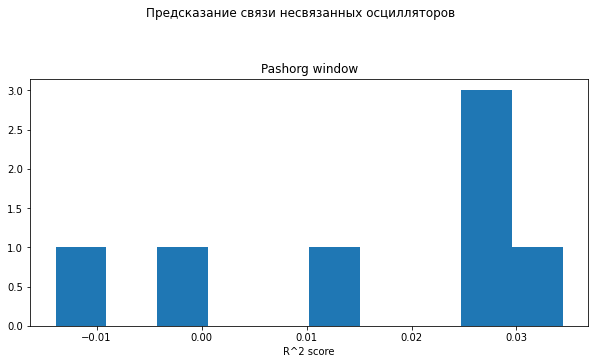

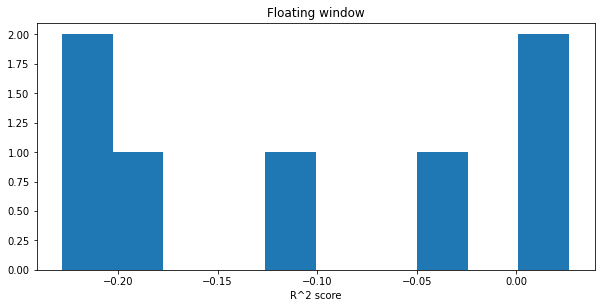

In [ ]:
plt.figure(figsize=(10, 10))
plt.suptitle('Предсказание связи несвязанных осцилляторов')
plt.subplot(2,1,1)
plt.title('Pashorg window')
plt.xlabel('R^2 score')
plt.hist(coefs2, bins=10)
plt.figure(figsize=(10, 10))
plt.subplot(2,1,2)
plt.title('Floating window')
plt.hist(coefs1, bins=10);
plt.xlabel('R^2 score')

In [ ]:
print(f'Pashorg window mean: {np.mean(coefs2)}\nstandard deviation: {stdev(coefs2)}')
print(f'Floating window mean: {np.mean(coefs1)}\nstandard deviation: {stdev(coefs1)}')

Pashorg window mean: 0.015841116620689672
standard deviation: 0.018469957597036457
Floating window mean: -0.10717418057863724
standard deviation: 0.10697441221387101


In [ ]:
coefs2.shape

(255,)

In [ ]:
test_data = {}
test_data['pashorg window'] = list(coefs1)
test_data['floating window'] = list(coefs2)

In [ ]:
import json
file = open('data.json', 'w')
json.dump(test_data, file)
file.close()

In [26]:
import json
e_variants = [(0, 0.03), (0.03, 0.03), (0., 0.15), (0.15, 0.15)]
window_variants = [(FloatingWindow, 'FloatingWindow'), (PashorgWindow, 'PashorgWindow')]
window_sizes = [(1.5, 1.5, 1), (3., 3., 1), (5, 5, 1), (10, 10, 1), (30, 30, 1)]
total = len(e_variants)*len(window_variants)*len(window_sizes)
result = []
i = 0
for e_variant in e_variants:
    for window_variant in window_variants:
        for window_size in window_sizes:
            update_progress(i/total)
            temp = {}
            arrs = get_osc(epsylon=e_variant, fps=50)
            arr_src = arrs[0]
            arr_trgt = arrs[1]
            win = window_variant[0](arr_src, arr_trgt, sfreq=50, twin=window_size[0], vwin=window_size[1], step=window_size[2])
            win.test_train()
            coefs = win.coefs
            temp['epsylon'] = e_variant
            temp['train type'] = window_variant[1]
            temp['coefs'] = coefs
            temp['mean'] = np.mean(coefs)
            temp['stdev'] = stdev(coefs)
            temp['window sizes'] = window_size
            result.append(temp)
            file = open('drive/My Drive/data.json', 'w')
            json.dump(result, file)
            file.close()
            i += 1


Progress: [####################] 97.5%


In [22]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)